## Dependencies

In [2]:
pip install PyPDF2 streamlit langchain-groq langchain-openai langchain-community faiss-cpu umap-learn matplotlib 

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.

   ---------------------------------------- 0.0/85.7 kB ? eta -:--:--
   ---- ----------------------------------- 10.2/85.7 kB ? eta -:--:--
   -------------- ------------------------- 30.7/85.7 kB 660.6 kB/s eta 0:00:01
   -------------- ------------------------- 30.7/85.7 kB 660.6 kB/s eta 0:00:01
   -------------- ------------------------- 30.7/85.7 kB 660.6 kB/s eta 0:00:01
   -------------- ------------------------- 30.7/85.7 kB 660.6 kB/s eta 0:00:01
   ------------------- -------------------- 41.0/85.7 kB 151.3 kB/s eta 0:00:01
   ---------------------------- ----------- 61.4/85.7 kB 218.8 kB/s eta 0:00:01
   ---------------------------------------- 85.7/85.7 kB 268.6 kB/s eta 0:00:00
   ---------------------------------------- 0.0/56.9 kB ? eta -:--:--
   ------------------------------------ --- 51.2/56.9 kB 1.3 MB/s eta 0:00:01
   ----

## Imports

In [27]:
import os
import getpass
import streamlit as st
from PyPDF2 import PdfReader
from langchain_groq import ChatGroq
from langchain.text_splitter import CharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate 
from langchain.schema.runnable import RunnablePassthrough
from langchain.schema.output_parser import StrOutputParser
import numpy as np
import umap
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

## Environment Setup

In [4]:
# Set API Keys
os.environ["GROQ_API_KEY"] = getpass.getpass(prompt="Enter your GROQ API Key: ")
groq_api_key = os.environ["GROQ_API_KEY"]

Enter your GROQ API Key:  ········


In [5]:
os.environ["OPENAI_API_KEY"] = getpass.getpass(prompt="Enter your OpenAI API Key: ")

Enter your OpenAI API Key:  ········


## Loading and Chunking

In [ ]:
# Read PDF and extract text
pdf = "microsoft_annual_report_2022.pdf"
pdf_reader = PdfReader(pdf)
text = ""
for page in pdf_reader.pages:
    text += page.extract_text()

# Split text into chunks
text_splitter = CharacterTextSplitter(
    separator="\n",
    chunk_size=500,
    chunk_overlap=100,
    length_function=len,
)
chunks = text_splitter.split_text(text)

## Embedding and Retrieval

In [ ]:
# Create embeddings and vectorstore
embeddings = OpenAIEmbeddings()
vectorstore = FAISS.from_texts(chunks, embeddings)

# Create retriever
retriever = vectorstore.as_retriever()

## LLM and Prompt

In [8]:
# Initialize LLM
llm = ChatGroq(
    temperature=0,
    model="llama3-70b-8192",
    api_key=groq_api_key
)

# Define prompt template
template = """ you are a helpful pdf assistant. 
        Given the following pdf, answer the question based on the context.
        If you don't know the answer, just say that you don't know.

        Question: {question}
        Context: {context}
        
        Answer:"""

question ="summarize Microsoft annual report"
prompt = ChatPromptTemplate.from_template(template)

## RAG chain

In [9]:
# Create RAG chain
rag_chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

# Get the answer
answer = rag_chain.invoke(question)
print("Answer:", answer)

Answer: Based on the provided PDF content, here is a summary of Microsoft's annual report:

Microsoft is a technology company that aims to empower every person and organization to achieve more. The company has a global presence, striving to create local opportunities, growth, and impact in every country.

The financial highlights of the report include:

* Total revenue: $166,368 million (2022), $128,314 million (2021), and $103,293 million (2020)
* Revenue breakdown by region:
	+ United States: $106,430 million (2022), $76,153 million (2021), and $60,789 million (2020)
	+ Ireland: $15,505 million (2022), $13,303 million (2021), and $12,734 million (2020)
	+ Other countries: $44,433 million (2022), $38,858 million (2021), and $29,770 million (2020)

The report also includes an audit opinion from an independent registered public accounting firm, which expresses an unqualified opinion on the company's financial statements and internal control over financial reporting as of June 30, 2022.


## Projecting the embedded vectors onto a 2D plane

C:\Users\abhisheka\AppData\Local\Temp\ipykernel_9268\2392502423.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embedding_vectors_2d[:, 0], embedding_vectors_2d[:, 1], s=5, cmap='Spectral', alpha=0.7)


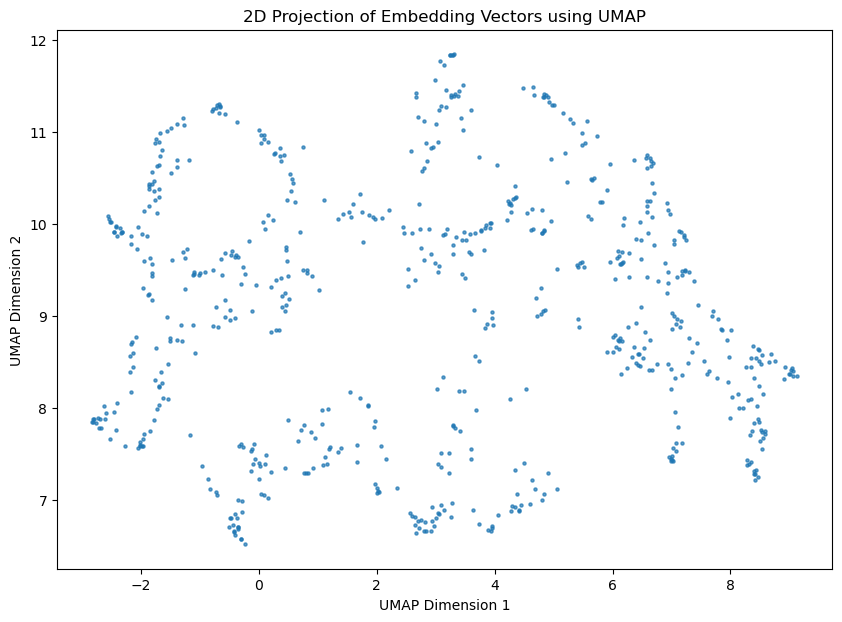

In [11]:
# Extract embedding vectors from FAISS index
num_vectors = vectorstore.index.ntotal
embedding_vectors = vectorstore.index.reconstruct_n(0, num_vectors)

# Apply UMAP for dimensionality reduction
reducer = umap.UMAP(n_components=2)
embedding_vectors_2d = reducer.fit_transform(embedding_vectors)

# Plot the 2D projection
plt.figure(figsize=(10, 7))
plt.scatter(embedding_vectors_2d[:, 0], embedding_vectors_2d[:, 1], s=5, cmap='Spectral', alpha=0.7)
plt.title('2D Projection of Embedding Vectors using UMAP')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()

## Projecting onto a 3D Euclidean static space

C:\Users\abhisheka\AppData\Local\Temp\ipykernel_9268\3648892076.py:16: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(embedding_vectors_3d[:, 0], embedding_vectors_3d[:, 1], embedding_vectors_3d[:, 2], s=5, cmap='Spectral', alpha=0.7)


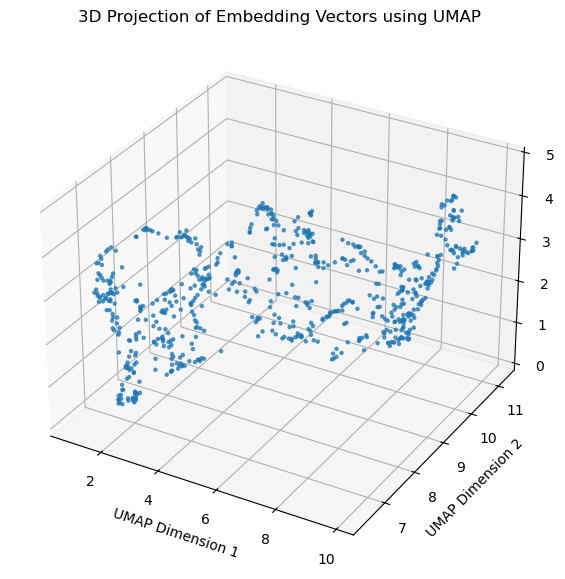

In [12]:
import umap
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Extract embedding vectors from FAISS index
num_vectors = vectorstore.index.ntotal
embedding_vectors = vectorstore.index.reconstruct_n(0, num_vectors)

# Apply UMAP for 3D dimensionality reduction
reducer_3d = umap.UMAP(n_components=3)
embedding_vectors_3d = reducer_3d.fit_transform(embedding_vectors)

# Plot the 3D projection
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(embedding_vectors_3d[:, 0], embedding_vectors_3d[:, 1], embedding_vectors_3d[:, 2], s=5, cmap='Spectral', alpha=0.7)
ax.set_title('3D Projection of Embedding Vectors using UMAP')
ax.set_xlabel('UMAP Dimension 1')
ax.set_ylabel('UMAP Dimension 2')
ax.set_zlabel('UMAP Dimension 3')
plt.show()


## Projecting onto a 3D Euclidean dynamic space

In [23]:
pip install plotly

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [29]:
# Extract embedding vectors from FAISS index
num_vectors = vectorstore.index.ntotal
embedding_vectors = vectorstore.index.reconstruct_n(0, num_vectors)

# Apply UMAP for 3D dimensionality reduction
reducer_3d = umap.UMAP(n_components=3)
embedding_vectors_3d = reducer_3d.fit_transform(embedding_vectors)

# Plot the 3D projection using Plotly
fig = px.scatter_3d(
    x=embedding_vectors_3d[:, 0],
    y=embedding_vectors_3d[:, 1],
    z=embedding_vectors_3d[:, 2],
    opacity=0.7,
    title='3D Projection of Embedding Vectors using UMAP'
)
fig.update_layout(scene = dict(
                    xaxis_title='UMAP Dimension 1',
                    yaxis_title='UMAP Dimension 2',
                    zaxis_title='UMAP Dimension 3'))
fig.show()

In [30]:
# Extract embedding vectors from FAISS index
num_vectors = vectorstore.index.ntotal
embedding_vectors = vectorstore.index.reconstruct_n(0, num_vectors)

# Compute the query embedding vector
query_embedding = embeddings.embed_documents([question])[0]

# Add the query embedding to the document embeddings
all_embeddings = np.vstack((embedding_vectors, query_embedding))

# Apply UMAP for 3D dimensionality reduction
reducer_3d = umap.UMAP(n_components=3)
embedding_vectors_3d = reducer_3d.fit_transform(all_embeddings)

# Separate document embeddings and query embedding for plotting
doc_embeddings_3d = embedding_vectors_3d[:-1]
query_embedding_3d = embedding_vectors_3d[-1]

# Perform similarity search
distances, indices = vectorstore.index.search(np.array([query_embedding]), k=5)

# Plot the 3D projection using Plotly
fig = px.scatter_3d(
    x=doc_embeddings_3d[:, 0],
    y=doc_embeddings_3d[:, 1],
    z=doc_embeddings_3d[:, 2],
    opacity=0.7,
    title='3D Projection of Embedding Vectors using UMAP'
)

# Add the query embedding to the plot with a different color
fig.add_trace(go.Scatter3d(
    x=[query_embedding_3d[0]],
    y=[query_embedding_3d[1]],
    z=[query_embedding_3d[2]],
    mode='markers',
    marker=dict(size=8, color='red'),
    name='Query Embedding'
))

# Highlight the top 5 most similar document embeddings
fig.add_trace(go.Scatter3d(
    x=doc_embeddings_3d[indices[0], 0],
    y=doc_embeddings_3d[indices[0], 1],
    z=doc_embeddings_3d[indices[0], 2],
    mode='markers',
    marker=dict(size=6, color='green'),
    name='Top 5 Similar Embeddings'
))

fig.update_layout(scene=dict(
    xaxis_title='UMAP Dimension 1',
    yaxis_title='UMAP Dimension 2',
    zaxis_title='UMAP Dimension 3'
))
fig.show()